### Imports 

In [1]:
from sagemaker.tensorflow.serving import TensorFlowModel
from sagemaker.multidatamodel import MultiDataModel
from sagemaker.tensorflow import TensorFlow
from sagemaker.inputs import TrainingInput
from sagemaker import get_execution_role
from datetime import datetime
import tensorflow as tf
import sagemaker
import time
import boto3
import os

In [2]:
print(f'Using TensorFlow version: {tf.__version__}')
print(f'Using SageMaker version: {sagemaker.__version__}')

Using TensorFlow version: 2.3.0
Using SageMaker version: 2.16.1


### Essentials

In [3]:
role = get_execution_role()
session = boto3.Session()
sagemaker_session = sagemaker.Session()

s3 = session.resource('s3')
TF_FRAMEWORK_VERSION = '2.3.0'
BUCKET = 'tf-mme-892313895307' # USE YOUR ACCOUNT ID OR INITIALS AS SUFFIX
PREFIX = 'cv-models'

## Model 1 - CIFAR-10 Image Classification

### Copy Train & Validation Data to S3

In [4]:
!aws s3 cp ./DATA/CIFAR_10/train s3://{BUCKET}/{PREFIX}/cifar/train --recursive

upload: DATA/CIFAR_10/train/y_train.npy to s3://tf-mme-892313895307/cv-models/cifar/train/y_train.npy
upload: DATA/CIFAR_10/train/X_train.npy to s3://tf-mme-892313895307/cv-models/cifar/train/X_train.npy


In [5]:
!aws s3 cp ./DATA/CIFAR_10/validation s3://{BUCKET}/{PREFIX}/cifar/validation --recursive

upload: DATA/CIFAR_10/validation/y_validation.npy to s3://tf-mme-892313895307/cv-models/cifar/validation/y_validation.npy
upload: DATA/CIFAR_10/validation/X_validation.npy to s3://tf-mme-892313895307/cv-models/cifar/validation/X_validation.npy


In [6]:
!aws s3 cp ./DATA/CIFAR_10/test s3://{BUCKET}/{PREFIX}/cifar/test --recursive

upload: DATA/CIFAR_10/test/y_test.npy to s3://tf-mme-892313895307/cv-models/cifar/test/y_test.npy
upload: DATA/CIFAR_10/test/X_test.npy to s3://tf-mme-892313895307/cv-models/cifar/test/X_test.npy


In [7]:
train_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/cifar/train', 
                            distribution='FullyReplicated', 
                            content_type='npy')
validation_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/cifar/validation', 
                                 distribution='FullyReplicated', 
                                 content_type='npy')
test_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/cifar/test', 
                           distribution='FullyReplicated', 
                           content_type='npy')

In [8]:
inputs = {'train': train_input, 'val': validation_input, 'test': test_input}

### Estimator 1

In [9]:
model_name = 'model-1'
hyperparameters = {'epochs': 30}
estimator_parameters = {'entry_point':'cifar_train.py',
                        'instance_type': 'ml.m5.2xlarge',
                        'instance_count': 1,
                        'model_dir': f'/opt/ml/model',
                        'role': role,
                        'hyperparameters': hyperparameters,
                        'output_path': f's3://{BUCKET}/{PREFIX}/cifar/out',
                        'base_job_name': f'cv-{model_name}',
                        'framework_version': TF_FRAMEWORK_VERSION,
                        'py_version': 'py37',
                        'script_mode': True}
estimator_1 = TensorFlow(**estimator_parameters)

In [10]:
estimator_1.fit(inputs)

2020-11-29 02:00:00 Starting - Starting the training job...
2020-11-29 02:00:03 Starting - Launching requested ML instances.........
2020-11-29 02:01:36 Starting - Preparing the instances for training...
2020-11-29 02:02:15 Downloading - Downloading input data...
2020-11-29 02:02:52 Training - Training image download completed. Training in progress..2020-11-29 02:02:56,316 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2020-11-29 02:02:56,323 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-11-29 02:02:56,663 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-11-29 02:02:56,678 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-11-29 02:02:56,693 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-11-29 02:02:56,703 sagemaker-training-toolkit INFO     Invoking user script

Training Env:

{
  

1546/1546 - 42s - loss: 1.7539 - accuracy: 0.3720 - val_loss: 1.5485 - val_accuracy: 0.4320
Epoch 2/30
1546/1546 - 41s - loss: 1.5361 - accuracy: 0.4431 - val_loss: 1.4913 - val_accuracy: 0.4760
Epoch 3/30
1546/1546 - 40s - loss: 1.4749 - accuracy: 0.4660 - val_loss: 1.2527 - val_accuracy: 0.5440
Epoch 4/30
1546/1546 - 40s - loss: 1.4264 - accuracy: 0.4843 - val_loss: 1.3447 - val_accuracy: 0.5340
Epoch 5/30
1546/1546 - 40s - loss: 1.3951 - accuracy: 0.5000 - val_loss: 1.2098 - val_accuracy: 0.5580
Epoch 6/30
1546/1546 - 40s - loss: 1.3590 - accuracy: 0.5125 - val_loss: 1.1046 - val_accuracy: 0.5880
Epoch 7/30
1546/1546 - 39s - loss: 1.3449 - accuracy: 0.5160 - val_loss: 1.2385 - val_accuracy: 0.5540
Epoch 8/30
1546/1546 - 40s - loss: 1.3203 - accuracy: 0.5275 - val_loss: 1.1772 - val_accuracy: 0.5580
Epoch 9/30
1546/1546 - 40s - loss: 1.3102 - accuracy: 0.5311 - val_loss: 1.1370 - val_accuracy: 0.5820
Epoch 10/30
1546/1546 - 40s - loss: 1.2884 - accuracy: 0.5410 - val_loss: 1.0257 - v


2020-11-29 02:23:17 Uploading - Uploading generated training model
2020-11-29 02:23:17 Completed - Training job completed
Training seconds: 1262
Billable seconds: 1262


## Model 2 - Sign Language Classification 

### Copy Train & Validation Data to S3

In [11]:
!aws s3 cp ./DATA/SIGN_LANGUAGE/ s3://{BUCKET}/{PREFIX}/sign_lang --recursive

upload: DATA/SIGN_LANGUAGE/test/.DS_Store to s3://tf-mme-892313895307/cv-models/sign_lang/test/.DS_Store
upload: DATA/SIGN_LANGUAGE/test/0/IMG_4159.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/test/0/IMG_4159.JPG
upload: DATA/SIGN_LANGUAGE/.DS_Store to s3://tf-mme-892313895307/cv-models/sign_lang/.DS_Store
upload: DATA/SIGN_LANGUAGE/test/0/IMG_4725.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/test/0/IMG_4725.JPG
upload: DATA/SIGN_LANGUAGE/test/1/IMG_4497.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/test/1/IMG_4497.JPG
upload: DATA/SIGN_LANGUAGE/test/2/IMG_5342.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/test/2/IMG_5342.JPG
upload: DATA/SIGN_LANGUAGE/test/0/IMG_4976.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/test/0/IMG_4976.JPG
upload: DATA/SIGN_LANGUAGE/test/1/IMG_5309.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/test/1/IMG_5309.JPG
upload: DATA/SIGN_LANGUAGE/test/0/IMG_5572.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/test/0/IMG_5572

upload: DATA/SIGN_LANGUAGE/train/0/IMG_4069.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_4069.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_4079.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_4079.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_4119.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_4119.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_4059.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_4059.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_4149.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_4149.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_4109.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_4109.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_4193.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_4193.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_4129.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_4129.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_4170.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/0/IMG_4996.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_4996.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_5101.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_5101.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_5091.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_5091.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_5122.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_5122.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_5017.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_5017.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_5132.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_5132.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_5142.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_5142.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_5007.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_5007.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_5152.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/1/IMG_1170.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_1170.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_5981.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_5981.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_1180.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_1180.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_1139.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_1139.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_1190.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_1190.JPG
upload: DATA/SIGN_LANGUAGE/train/0/IMG_5991.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/0/IMG_5991.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_1220.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_1220.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_1200.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_1200.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_1271.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/1/IMG_4806.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_4806.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_4827.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_4827.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_4787.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_4787.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_4907.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_4907.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_4847.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_4847.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_4927.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_4927.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_4877.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_4877.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_4957.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_4957.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_4897.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/1/IMG_5696.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_5696.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_5757.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_5757.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_5727.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_5727.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_5767.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_5767.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_5686.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_5686.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_5747.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_5747.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_5777.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_5777.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_5807.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/1/IMG_5807.JPG
upload: DATA/SIGN_LANGUAGE/train/1/IMG_5858.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/2/IMG_4425.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/2/IMG_4425.JPG
upload: DATA/SIGN_LANGUAGE/train/2/IMG_4556.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/2/IMG_4556.JPG
upload: DATA/SIGN_LANGUAGE/train/2/IMG_4393.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/2/IMG_4393.JPG
upload: DATA/SIGN_LANGUAGE/train/2/IMG_4545.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/2/IMG_4545.JPG
upload: DATA/SIGN_LANGUAGE/train/2/IMG_4616.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/2/IMG_4616.JPG
upload: DATA/SIGN_LANGUAGE/train/2/IMG_4535.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/2/IMG_4535.JPG
upload: DATA/SIGN_LANGUAGE/train/2/IMG_4566.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/2/IMG_4566.JPG
upload: DATA/SIGN_LANGUAGE/train/2/IMG_4596.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/2/IMG_4596.JPG
upload: DATA/SIGN_LANGUAGE/train/2/IMG_4646.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/2/IMG_5392.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/2/IMG_5392.JPG
upload: DATA/SIGN_LANGUAGE/train/2/IMG_5458.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/2/IMG_5458.JPG
upload: DATA/SIGN_LANGUAGE/train/2/IMG_5382.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/2/IMG_5382.JPG
upload: DATA/SIGN_LANGUAGE/train/2/IMG_5448.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/2/IMG_5448.JPG
upload: DATA/SIGN_LANGUAGE/train/2/IMG_5468.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/2/IMG_5468.JPG
upload: DATA/SIGN_LANGUAGE/train/2/IMG_5488.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/2/IMG_5488.JPG
upload: DATA/SIGN_LANGUAGE/train/2/IMG_5539.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/2/IMG_5539.JPG
upload: DATA/SIGN_LANGUAGE/train/2/IMG_5478.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/2/IMG_5478.JPG
upload: DATA/SIGN_LANGUAGE/train/2/IMG_5509.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/3/IMG_4152.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_4152.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_4142.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_4142.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_4216.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_4216.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_4236.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_4236.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_4174.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_4174.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_4206.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_4206.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_4162.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_4162.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_4196.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_4196.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_4246.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/3/IMG_5066.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_5066.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_5034.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_5034.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_5125.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_5125.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_5104.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_5104.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_5020.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_5020.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_5078.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_5078.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_5056.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_5056.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_4969.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_4969.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_5094.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/3/IMG_5994.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_5994.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_5984.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_5984.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_1132.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_1132.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_5974.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_5974.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_1122.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_1122.JPG
upload: DATA/SIGN_LANGUAGE/train/3/IMG_5900.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/3/IMG_5900.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_1193.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_1193.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_1152.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_1152.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_1162.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/4/IMG_4790.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_4790.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_4698.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_4698.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_4800.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_4800.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_4648.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_4648.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_4780.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_4780.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_4850.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_4850.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_4749.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_4749.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_4880.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_4880.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_4910.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/4/IMG_5629.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_5629.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_5699.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_5699.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_5669.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_5669.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_5689.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_5689.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_5639.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_5639.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_5720.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_5720.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_5709.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_5709.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_5760.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/4/IMG_5760.JPG
upload: DATA/SIGN_LANGUAGE/train/4/IMG_5750.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/5/IMG_4375.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/5/IMG_4375.JPG
upload: DATA/SIGN_LANGUAGE/train/5/IMG_4441.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/5/IMG_4441.JPG
upload: DATA/SIGN_LANGUAGE/train/5/IMG_4386.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/5/IMG_4386.JPG
upload: DATA/SIGN_LANGUAGE/train/5/IMG_4418.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/5/IMG_4418.JPG
upload: DATA/SIGN_LANGUAGE/train/5/IMG_4396.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/5/IMG_4396.JPG
upload: DATA/SIGN_LANGUAGE/train/5/IMG_4491.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/5/IMG_4491.JPG
upload: DATA/SIGN_LANGUAGE/train/5/IMG_4481.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/5/IMG_4481.JPG
upload: DATA/SIGN_LANGUAGE/train/5/IMG_4461.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/5/IMG_4461.JPG
upload: DATA/SIGN_LANGUAGE/train/5/IMG_4589.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/5/IMG_5385.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/5/IMG_5385.JPG
upload: DATA/SIGN_LANGUAGE/train/5/IMG_5405.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/5/IMG_5405.JPG
upload: DATA/SIGN_LANGUAGE/train/5/IMG_5365.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/5/IMG_5365.JPG
upload: DATA/SIGN_LANGUAGE/train/5/IMG_5395.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/5/IMG_5395.JPG
upload: DATA/SIGN_LANGUAGE/train/5/IMG_5334.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/5/IMG_5334.JPG
upload: DATA/SIGN_LANGUAGE/train/5/IMG_5461.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/5/IMG_5461.JPG
upload: DATA/SIGN_LANGUAGE/train/5/IMG_5417.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/5/IMG_5417.JPG
upload: DATA/SIGN_LANGUAGE/train/5/IMG_5427.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/5/IMG_5427.JPG
upload: DATA/SIGN_LANGUAGE/train/5/IMG_5375.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/6/IMG_4199.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_4199.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_4187.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_4187.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_4135.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_4135.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_4045.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_4045.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_4125.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_4125.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_4165.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_4165.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_4209.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_4209.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_4177.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_4177.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_4229.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/6/IMG_5049.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_5049.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_4922.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_4922.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_5059.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_5059.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_5081.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_5081.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_5069.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_5069.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_5138.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_5138.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_5189.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_5189.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_5107.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_5107.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_5169.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/6/IMG_5966.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_5966.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_5946.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_5946.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_5873.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_5873.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_5977.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_5977.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_1135.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_1135.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_5997.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_5997.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_5956.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/6/IMG_5956.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_1145.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_1145.JPG
upload: DATA/SIGN_LANGUAGE/train/6/IMG_5987.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/7/IMG_4712.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_4712.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_4742.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_4742.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_4722.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_4722.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_4793.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_4793.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_4752.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_4752.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_4783.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_4783.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_4681.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_4681.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_4701.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_4701.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_4823.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/7/IMG_5622.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_5622.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_5642.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_5642.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_5632.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_5632.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_5652.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_5652.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_5723.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_5723.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_5662.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_5662.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_5672.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_5672.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_5712.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/7/IMG_5712.JPG
upload: DATA/SIGN_LANGUAGE/train/7/IMG_5733.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/8/IMG_4356.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/8/IMG_4356.JPG
upload: DATA/SIGN_LANGUAGE/train/8/IMG_4367.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/8/IMG_4367.JPG
upload: DATA/SIGN_LANGUAGE/train/8/IMG_4421.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/8/IMG_4421.JPG
upload: DATA/SIGN_LANGUAGE/train/8/IMG_4411.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/8/IMG_4411.JPG
upload: DATA/SIGN_LANGUAGE/train/8/IMG_4399.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/8/IMG_4399.JPG
upload: DATA/SIGN_LANGUAGE/train/8/IMG_4389.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/8/IMG_4389.JPG
upload: DATA/SIGN_LANGUAGE/train/8/IMG_4444.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/8/IMG_4444.JPG
upload: DATA/SIGN_LANGUAGE/train/8/IMG_4432.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/8/IMG_4432.JPG
upload: DATA/SIGN_LANGUAGE/train/8/IMG_4474.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/8/IMG_5211.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/8/IMG_5211.JPG
upload: DATA/SIGN_LANGUAGE/train/8/IMG_5242.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/8/IMG_5242.JPG
upload: DATA/SIGN_LANGUAGE/train/8/IMG_5326.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/8/IMG_5326.JPG
upload: DATA/SIGN_LANGUAGE/train/8/IMG_5284.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/8/IMG_5284.JPG
upload: DATA/SIGN_LANGUAGE/train/8/IMG_5306.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/8/IMG_5306.JPG
upload: DATA/SIGN_LANGUAGE/train/8/IMG_5316.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/8/IMG_5316.JPG
upload: DATA/SIGN_LANGUAGE/train/8/IMG_5358.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/8/IMG_5358.JPG
upload: DATA/SIGN_LANGUAGE/train/8/IMG_5398.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/8/IMG_5398.JPG
upload: DATA/SIGN_LANGUAGE/train/8/IMG_5420.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/9/IMG_1137.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_1137.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_1311.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_1311.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_4068.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_4068.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_4058.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_4058.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_1331.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_1331.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_1300.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_1300.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_4078.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_4078.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_4108.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_4108.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_4098.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/9/IMG_4955.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_4955.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_5006.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_5006.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_5040.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_5040.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_4965.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_4965.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_5062.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_5062.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_5052.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_5052.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_4995.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_4995.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_5026.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_5026.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_4975.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/train/9/IMG_5866.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_5866.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_5937.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_5937.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_5927.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_5927.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_5876.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_5876.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_5959.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_5959.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_5949.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_5949.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_5896.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_5896.JPG
upload: DATA/SIGN_LANGUAGE/train/9/IMG_5980.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/train/9/IMG_5980.JPG
upload: DATA/SIGN_LANGUAGE/valid/0/IMG_4181.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/valid/1/IMG_5908.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/1/IMG_5908.JPG
upload: DATA/SIGN_LANGUAGE/valid/2/IMG_4061.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/2/IMG_4061.JPG
upload: DATA/SIGN_LANGUAGE/valid/2/IMG_4298.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/2/IMG_4298.JPG
upload: DATA/SIGN_LANGUAGE/valid/1/IMG_5563.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/1/IMG_5563.JPG
upload: DATA/SIGN_LANGUAGE/valid/2/IMG_4372.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/2/IMG_4372.JPG
upload: DATA/SIGN_LANGUAGE/valid/2/IMG_1241.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/2/IMG_1241.JPG
upload: DATA/SIGN_LANGUAGE/valid/2/IMG_4308.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/2/IMG_4308.JPG
upload: DATA/SIGN_LANGUAGE/valid/2/IMG_4141.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/2/IMG_4141.JPG
upload: DATA/SIGN_LANGUAGE/valid/2/IMG_1201.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/valid/4/IMG_5136.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/4/IMG_5136.JPG
upload: DATA/SIGN_LANGUAGE/valid/4/IMG_4073.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/4/IMG_4073.JPG
upload: DATA/SIGN_LANGUAGE/valid/4/IMG_4810.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/4/IMG_4810.JPG
upload: DATA/SIGN_LANGUAGE/valid/4/IMG_5187.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/4/IMG_5187.JPG
upload: DATA/SIGN_LANGUAGE/valid/4/IMG_5177.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/4/IMG_5177.JPG
upload: DATA/SIGN_LANGUAGE/valid/4/IMG_5531.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/4/IMG_5531.JPG
upload: DATA/SIGN_LANGUAGE/valid/4/IMG_5619.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/4/IMG_5619.JPG
upload: DATA/SIGN_LANGUAGE/valid/4/IMG_5576.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/4/IMG_5576.JPG
upload: DATA/SIGN_LANGUAGE/valid/4/IMG_5820.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/valid/7/IMG_4503.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/7/IMG_4503.JPG
upload: DATA/SIGN_LANGUAGE/valid/7/IMG_1298.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/7/IMG_1298.JPG
upload: DATA/SIGN_LANGUAGE/valid/7/IMG_4443.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/7/IMG_4443.JPG
upload: DATA/SIGN_LANGUAGE/valid/7/IMG_4230.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/7/IMG_4230.JPG
upload: DATA/SIGN_LANGUAGE/valid/7/IMG_1267.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/7/IMG_1267.JPG
upload: DATA/SIGN_LANGUAGE/valid/7/IMG_4156.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/7/IMG_4156.JPG
upload: DATA/SIGN_LANGUAGE/valid/7/IMG_4493.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/7/IMG_4493.JPG
upload: DATA/SIGN_LANGUAGE/valid/7/IMG_4893.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/7/IMG_4893.JPG
upload: DATA/SIGN_LANGUAGE/valid/7/IMG_5004.JPG to s3://tf-mme-8

upload: DATA/SIGN_LANGUAGE/valid/9/IMG_4485.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/9/IMG_4485.JPG
upload: DATA/SIGN_LANGUAGE/valid/9/IMG_5285.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/9/IMG_5285.JPG
upload: DATA/SIGN_LANGUAGE/valid/9/IMG_5506.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/9/IMG_5506.JPG
upload: DATA/SIGN_LANGUAGE/valid/9/IMG_4422.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/9/IMG_4422.JPG
upload: DATA/SIGN_LANGUAGE/valid/9/IMG_4693.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/9/IMG_4693.JPG
upload: DATA/SIGN_LANGUAGE/valid/9/IMG_5296.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/9/IMG_5296.JPG
upload: DATA/SIGN_LANGUAGE/valid/9/IMG_5275.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/9/IMG_5275.JPG
upload: DATA/SIGN_LANGUAGE/valid/9/IMG_5485.JPG to s3://tf-mme-892313895307/cv-models/sign_lang/valid/9/IMG_5485.JPG
upload: DATA/SIGN_LANGUAGE/valid/9/IMG_4455.JPG to s3://tf-mme-8

In [12]:
train_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/sign_lang/train', 
                            distribution='ShardedByS3Key')
val_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/sign_lang/valid', 
                          distribution='ShardedByS3Key')

### Estimator 2

In [13]:
model_name = 'model-2'

hyperparameters = {'epochs': 20}
estimator_parameters = {'entry_point':'sign_language_train.py',
                        'instance_type': 'ml.m5.2xlarge',
                        'instance_count': 1,
                        'hyperparameters': hyperparameters,
                        'model_dir': f'/opt/ml/model',
                        'role': role,
                        'output_path': f's3://{BUCKET}/{PREFIX}/sign_lang/out',
                        'base_job_name': f'cv-{model_name}',
                        'framework_version': TF_FRAMEWORK_VERSION,
                        'py_version': 'py37',
                        'script_mode': True}

estimator_2 = TensorFlow(**estimator_parameters)

In [14]:
estimator_2.fit({'train': train_input, 'val': val_input})

2020-11-29 02:23:54 Starting - Starting the training job...
2020-11-29 02:23:57 Starting - Launching requested ML instances......
2020-11-29 02:25:11 Starting - Preparing the instances for training...
2020-11-29 02:25:48 Downloading - Downloading input data...
2020-11-29 02:26:18 Training - Downloading the training image..
2020-11-29 02:26:32 Training - Training image download completed. Training in progress.2020-11-29 02:26:37,149 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2020-11-29 02:26:37,157 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-11-29 02:26:37,761 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-11-29 02:26:37,778 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-11-29 02:26:37,795 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-11-29 02:26:37,805 sagemaker-trainin

#015 1/18 [>.............................] - ETA: 0s - loss: 11.5628 - accuracy: 0.0000e+00#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 2/18 [==>...........................] - ETA: 6s - loss: 9.0235 - accuracy: 0.0500     #010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/18 [====>.........................] - ETA: 7s - loss: 7.7095 - accuracy: 0.1000#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015 1/18 [>.............................] - ETA: 0s - loss: 1.1204 - accuracy: 0.5000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 2/18 [==>...........................] - ETA: 6s - loss: 1.1693 - accuracy: 0.6000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/18 [====>.........................] - ETA: 7s - loss: 1.0778 - accuracy: 0.6333#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015 1/18 [>.............................] - ETA: 0s - loss: 0.4219 - accuracy: 0.9000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 2/18 [==>...........................] - ETA: 6s - loss: 0.4820 - accuracy: 0.9000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/18 [====>.........................] - ETA: 7s - loss: 0.4568 - accuracy: 0.9000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015 1/18 [>.............................] - ETA: 0s - loss: 0.4786 - accuracy: 0.8000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 2/18 [==>...........................] - ETA: 5s - loss: 0.2550 - accuracy: 0.9000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/18 [====>.........................] - ETA: 7s - loss: 0.2698 - accuracy: 0.9000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015 1/18 [>.............................] - ETA: 0s - loss: 0.4362 - accuracy: 0.9000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 2/18 [==>...........................] - ETA: 5s - loss: 0.2909 - accuracy: 0.9500#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/18 [====>.........................] - ETA: 7s - loss: 0.2613 - accuracy: 0.9333#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015 1/18 [>.............................] - ETA: 0s - loss: 0.0413 - accuracy: 1.0000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 2/18 [==>...........................] - ETA: 6s - loss: 0.1074 - accuracy: 0.9500#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/18 [====>.........................] - ETA: 7s - loss: 0.1173 - accuracy: 0.9333#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015 1/18 [>.............................] - ETA: 0s - loss: 0.1025 - accuracy: 0.9000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 2/18 [==>...........................] - ETA: 5s - loss: 0.1490 - accuracy: 0.9000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/18 [====>.........................] - ETA: 7s - loss: 0.1056 - accuracy: 0.9333#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015 1/18 [>.............................] - ETA: 0s - loss: 0.0125 - accuracy: 1.0000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 2/18 [==>...........................] - ETA: 5s - loss: 0.0216 - accuracy: 1.0000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/18 [====>.........................] - ETA: 7s - loss: 0.0325 - accuracy: 1.0000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015 1/18 [>.............................] - ETA: 0s - loss: 0.0246 - accuracy: 1.0000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 2/18 [==>...........................] - ETA: 6s - loss: 0.1394 - accuracy: 0.9000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/18 [====>.........................] - ETA: 7s - loss: 0.0931 - accuracy: 0.9333#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015 1/18 [>.............................] - ETA: 0s - loss: 0.0185 - accuracy: 1.0000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 2/18 [==>...........................] - ETA: 5s - loss: 0.0217 - accuracy: 1.0000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/18 [====>.........................] - ETA: 7s - loss: 0.0210 - accuracy: 1.0000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0


2020-11-29 02:33:19 Uploading - Uploading generated training model
2020-11-29 02:33:38 Completed - Training job completed
Training seconds: 470
Billable seconds: 470


## Multi-Model Endpoint (MME)

In [15]:
tf_model_1 = estimator_1.model_data
output_1 = f's3://{BUCKET}/{PREFIX}/mme/model-1.tar.gz'

In [16]:
tf_model_2 = estimator_2.model_data
output_2 = f's3://{BUCKET}/{PREFIX}/mme/model-2.tar.gz'

In [17]:
!aws s3 cp {tf_model_1} {output_1} 
!aws s3 cp {tf_model_2} {output_2} 

copy: s3://tf-mme-892313895307/cv-models/cifar/out/cv-model-1-2020-11-29-01-59-59-893/output/model.tar.gz to s3://tf-mme-892313895307/cv-models/mme/model-1.tar.gz
copy: s3://tf-mme-892313895307/cv-models/sign_lang/out/cv-model-2-2020-11-29-02-23-54-493/output/model.tar.gz to s3://tf-mme-892313895307/cv-models/mme/model-2.tar.gz


### Deploy TensorFlow Model-1 as a Multi-Model Endpoint 
<p>https://github.com/aws/deep-learning-containers/blob/master/available_images.md</p>

In [18]:
current_time = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H-%M-%S')
current_time

'2020-11-29-02-34-18'

In [19]:
IMAGE_URI = '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.3.1-cpu-py37-ubuntu18.04'
model_data_prefix = f's3://{BUCKET}/{PREFIX}/mme/'
model_1 = TensorFlowModel(model_data=output_1, 
                          role=role, 
                          image_uri=IMAGE_URI)

In [20]:
mme = MultiDataModel(name=f'mme-tensorflow-{current_time}',
                     model_data_prefix=model_data_prefix,
                     model=model_1,
                     sagemaker_session=sagemaker_session)

In [21]:
predictor = mme.deploy(initial_instance_count=1,
                       instance_type='ml.m5.2xlarge',
                       endpoint_name=f'mme-tensorflow-{current_time}')

-------------!

In [22]:
list(mme.list_models())

['model-1.tar.gz', 'model-2.tar.gz']

### Test Multi-Model Endpoint for Real Time Inference 

#### Test Model-1 CIFAR Image Classification

In [30]:
%matplotlib inline
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from IPython.display import Image
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import numpy as np

In [24]:
CIFAR10_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

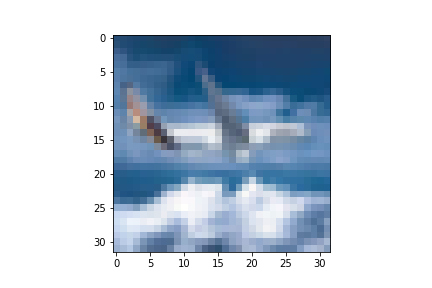

In [25]:
Image('./DATA/CIFAR_10/raw_images/airplane.png')

In [26]:
img = load_img('./DATA/CIFAR_10/raw_images/airplane.png', target_size=(32, 32))
data = img_to_array(img)
data = data.astype('float32')
data = data / 255.0
data = data.reshape(1, 32, 32, 3)

In [27]:
payload = {'instances': data}

In [28]:
y_pred = predictor.predict(data=payload, initial_args={'TargetModel': 'model-1.tar.gz'})

In [31]:
predicted_label = CIFAR10_LABELS[np.argmax(y_pred)]
print(f'Predicted Label: [{predicted_label}]')

Predicted Label: [airplane]


#### Test Model-2 Sign Language Classification

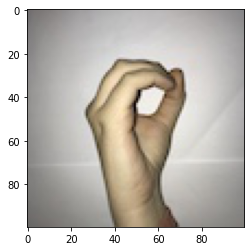

In [32]:
test_path  = './DATA/SIGN_LANGUAGE/test'
img = mpimg.imread(f'{test_path}/0/IMG_4159.JPG')
plt.imshow(img)

In [33]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [34]:
data = path_to_tensor(f'{test_path}/0/IMG_4159.JPG')
payload = {'instances': data}

In [35]:
y_pred = predictor.predict(data=payload, initial_args={'TargetModel': 'model-2.tar.gz'})

In [36]:
predicted_label = np.argmax(y_pred)
print(f'Predicted Label: [{predicted_label}]')

Predicted Label: [0]
